Multivariate distribution classification by multi-layer perceptron
====================================================

Generate the data
---------------

First we generate two populations of 2D points defined by their mean and their covariance. We use numpy random.multivariate_normal to generate them. We store them as pair in the x list. In the y list, we associate a label (0 for the first distribution, 1 for the second)

In [2]:
import numpy as np
x=[]
y=[]
for i in range(1024):
    t=np.random.multivariate_normal([0,0],[[0.4,0],[0,0.4]])
    x.append(t)
    y.append(0)
    t=np.random.multivariate_normal([3.4,3.4],[[0.6,0.4],[0.4,0.6]])
    x.append(t)
    y.append(1)

Plot the data
---------

We plot the data with a scatter plot from matplotlib. 
First the data are stored in three lists : px are the x coordinates of each point (the two distributions are mixed inside), py the y coordinates and c the color of the points which is just the 0/1 label from y

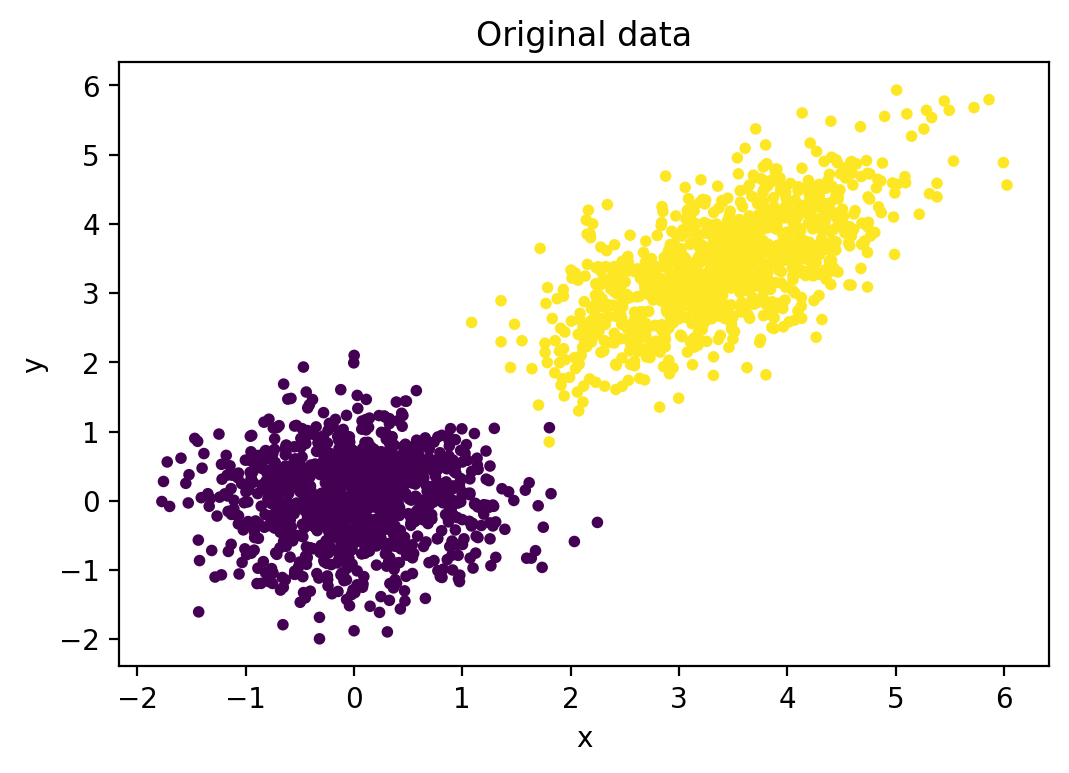

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200

px=[]
py=[]
c=[]

for i in range(len(x)):
    px.append(x[i][0])
    py.append(x[i][1])
    c.append(y[i])
                             
plt.scatter(px,py,c=c,s=10)
plt.title("Original data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

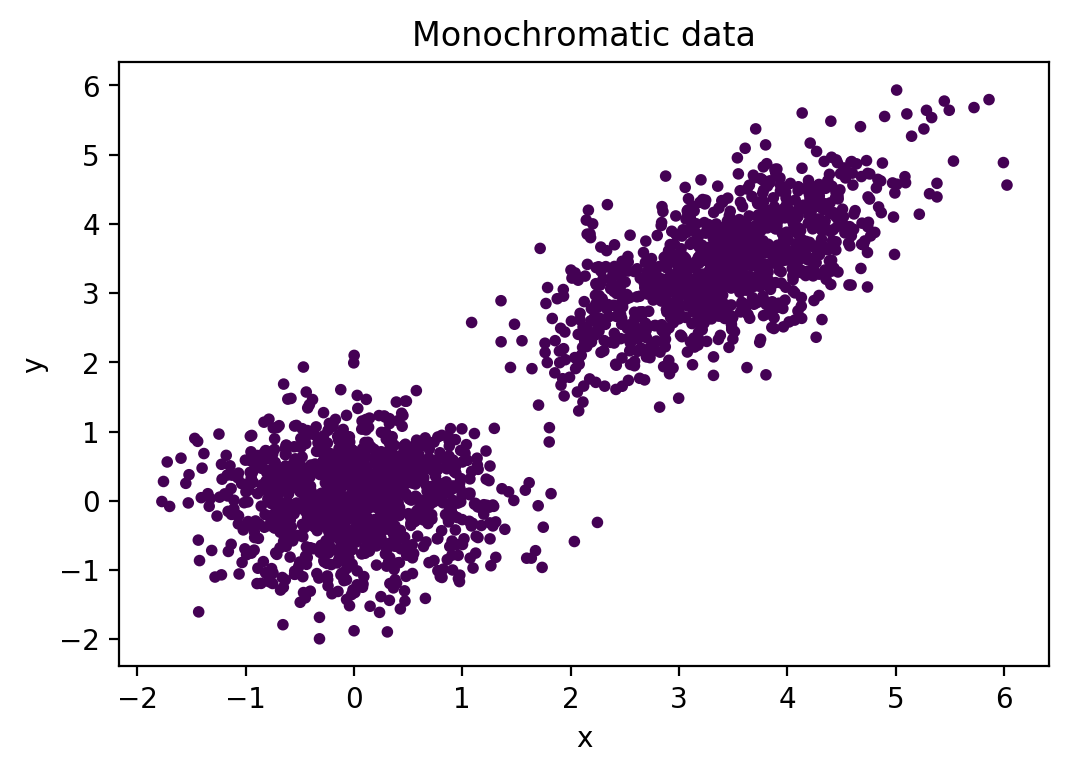

In [4]:
pxm=[]
pym=[]
cm=[]

for i in range(len(x)):
    pxm.append(x[i][0])
    pym.append(x[i][1])
    cm.append(0)
                             
plt.scatter(pxm,pym,c=cm,s=10)
plt.title("Monochromatic data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Format the data
--------

To train a Torch neural network, it is mandatory to convert the data to tensors.

In a second part, we decide to split the data in two parts : 90% for training and 10% for testing. We obtain two dataset train_set and test_set

Finally, we build dataloader which is a data grouping tool to provide mini-batch to learning process. We obtain two dataloaders train_loader and test_loader.

In [3]:
import torch
from torch.utils import data

tensor_x=torch.Tensor(x)
tensor_y=torch.Tensor(y)

dset=torch.utils.data.TensorDataset(tensor_x,tensor_y)
train_size=int(0.9*len(dset))
test_size=len(dset)-train_size
train_dset,test_dset=data.random_split(dset,[train_size,test_size])

train_loader=data.DataLoader(train_dset,batch_size=64)
test_loader=data.DataLoader(test_dset,batch_size=64)

Definition of the neural network
---------------------------------------------

It is a multi-layer perceptron with two hidden layers. It is defined as a class inheriting from the torch.nn.Module. The init of the base class must be called. 

The number of neurons in each layers are defined by the \__init\__ parameters. In this function, the three layers are created (fc1,fc2,fc3) and the transfer function are instanciated (relu for hidden layers and sigmoid for output layer)

The forward function defines what happen during a prediction : the input go through the first layer and through the Rectified Linear Unit function (relu). Then it goes the same way through the second the third layer. At the third layer, the transfer function is the sigmoid to guarantee that the output will be between 0 and 1 (mandatory for binary crossentropy). The result if the output of the sigmoid function which is only a float between 0 and 1 which will be compared with the 0/1 label.

In [4]:
class mlp(torch.nn.Module):
        def __init__(self,input_size,hidden_size_1,hidden_size_2):
            super(mlp, self).__init__()
            self.relu=torch.nn.ReLU()
            self.sigmoid=torch.nn.Sigmoid()
            self.fc1=torch.nn.Linear(input_size,hidden_size_1)
            self.fc2=torch.nn.Linear(hidden_size_1,hidden_size_2)
            self.fc3=torch.nn.Linear(hidden_size_2,1)

        def forward(self,input):
            x=self.fc1(input)
            x=self.relu(x)
            x=self.fc2(x)
            x=self.relu(x)
            x=self.fc3(x)
            x=self.sigmoid(x)
            return x

Instanciate the necessary tools
-------

The three components necessary to train our network are the network itself (here called model), the loss function (criterion) and the optimizer.

The network is chosen with an input size of 2, corresponding to the two coordinates of our input points. 50 neurons in the first hidden layer and 25 in the second one.

The loss function is the binary cross-entropy which is adapted to our 0/1 classification problematics.

The optimizer is a stochastic gradient descent with a learning rate of 0.01. It is the simplest optimizer with only one learning rate for all parameters and using batch derivatives to adjust them.

In [5]:
model=mlp(2,50,25)
criterion=torch.nn.BCELoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

In order to plot the loss function along the epochs, we create three empy list. ptr_loss to store the values of the loss function on the training set, pte_loss for the loss function on the testing set and pepoch for the epoch number.

In [6]:
ptr_loss=[]
pte_loss=[]
pepoch=[]

Train the network
--------

This part is the core of the training : the training loop. We iterate for 100 epochs. Inside the loop we have three blocks of code : 

### Training

applied on all mini-batches provided by train_loader : 

- zero the gradients in all variables managed by the optimizer (the model parameters)
- calculate the network prediction
- calculate the loss function for the batch (batch_loss)
- cumulate it in a variable for the whole epoch (train_cum_loss)
- calculate the gradients (backward)
- apply an optimizer step

### Testing

For each epoch, we also want to test the network on the testing set (to monitor overfitting). It is the same commands except that we dont apply optimizer. 

Note the model.train() command indicating to build computation graph to compute the derivatives and model.eval() which indicates not to do it to save performances.

### Storing

In this part, the loss functions sum are meaned and stored for plot in the ptr_loss and pte_loss lists. A print allow to follow the progression of the training.

In [7]:
nb_epoch=100
for epoch in range(nb_epoch):
    train_cum_loss=0.0
    
    model.train()
    for x_train,y_train in train_loader:
        optimizer.zero_grad()
        y_pred=model.forward(x_train)
        batch_loss=criterion(y_pred.squeeze(),y_train)
        train_cum_loss+=batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        
    test_cum_loss=0.0
    model.eval()
    for x_test,y_test in test_loader:
        y_pred=model.forward(x_test)
        batch_loss=criterion(y_pred.squeeze(),y_test) 
        test_cum_loss+=batch_loss.item()
        
    tr_loss=train_cum_loss/len(train_loader)
    te_loss=test_cum_loss/len(test_loader)
    print("Epoch %d: train loss : %f test loss: %f"%(epoch,tr_loss,te_loss))
    ptr_loss.append(tr_loss)
    pte_loss.append(te_loss)
    pepoch.append(epoch)

Epoch 0: train loss : 0.655430 test loss: 0.583486
Epoch 1: train loss : 0.544159 test loss: 0.488974
Epoch 2: train loss : 0.465507 test loss: 0.421320
Epoch 3: train loss : 0.406787 test loss: 0.370841
Epoch 4: train loss : 0.359913 test loss: 0.329367
Epoch 5: train loss : 0.319347 test loss: 0.292401
Epoch 6: train loss : 0.282509 test loss: 0.258497
Epoch 7: train loss : 0.248743 test loss: 0.227396
Epoch 8: train loss : 0.217994 test loss: 0.199318
Epoch 9: train loss : 0.190494 test loss: 0.174333
Epoch 10: train loss : 0.166363 test loss: 0.152489
Epoch 11: train loss : 0.145565 test loss: 0.133677
Epoch 12: train loss : 0.127795 test loss: 0.117588
Epoch 13: train loss : 0.112696 test loss: 0.103877
Epoch 14: train loss : 0.099903 test loss: 0.092213
Epoch 15: train loss : 0.089062 test loss: 0.082280
Epoch 16: train loss : 0.079862 test loss: 0.073805
Epoch 17: train loss : 0.072027 test loss: 0.066560
Epoch 18: train loss : 0.065328 test loss: 0.060335
Epoch 19: train loss :

Save the model
--

To a file model.pth

In [8]:
torch.save(model,"model.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type mlp. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Plot the loss values
----

with matplotlib. We can see that the test loss is always under the training loss which is fine (no over-fitting).

The test curve is under the train curve because it is called after (a complete epoch has been done before its evaluation).

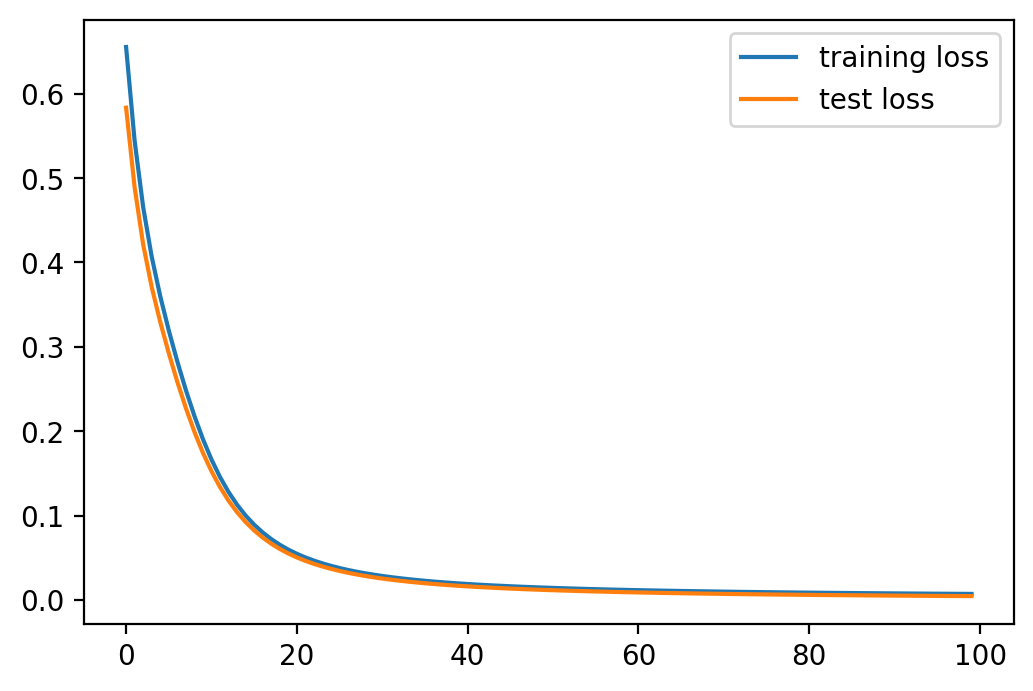

In [9]:
plt.plot(pepoch,ptr_loss,label="training loss")
plt.plot(pepoch,pte_loss,label="test loss")
plt.legend()
plt.show()

Plot the bad classifications
------

In this part, we store all the point in the px, py, c lists for plotting as in the generation step. But we add the badly classified points. To do this, we evaluate then one by one in a loop. 

evaluation is done by the forward function (which return a tensor). The results is converted to numpy. The result is compared in absolute value to the label. if the difference is too high (>0.4), the point is considered as badly classified and is append in the px,py with a special color (3).

Finally we plot the result, we see that only the points at the edge of the two domains are badly classified.

nb of bad classification : 4


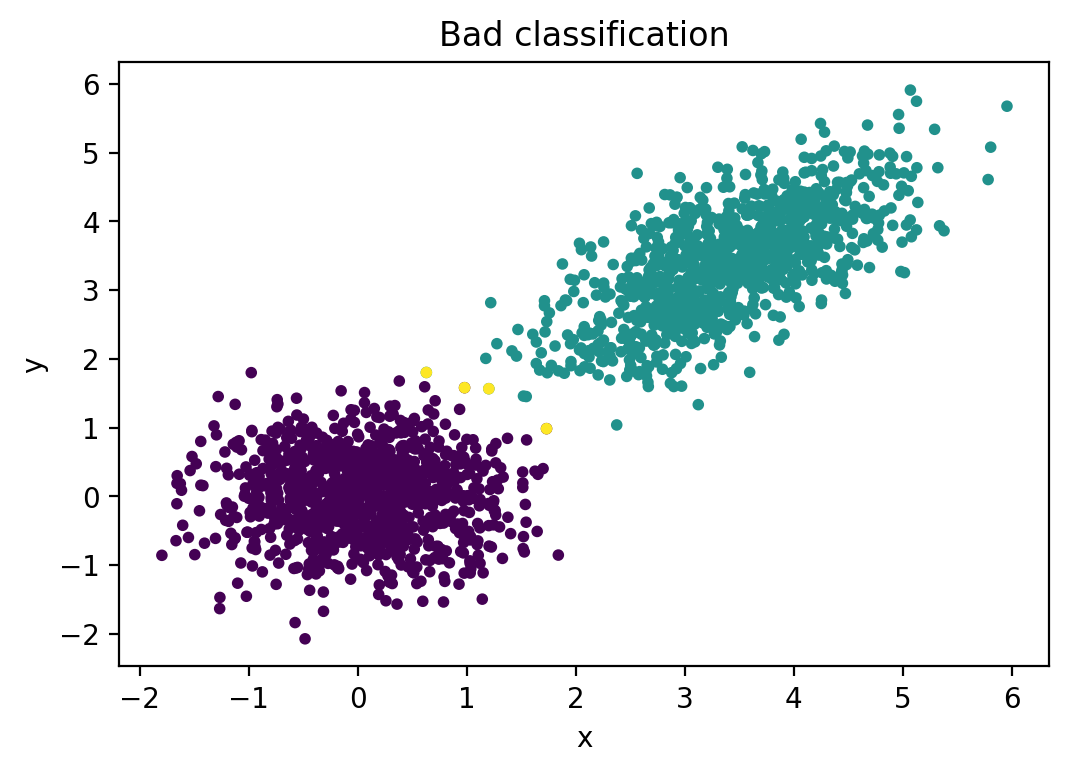

In [10]:
px=[]
py=[]
c=[]

for i in range(len(x)):
    px.append(x[i][0])
    py.append(x[i][1])
    c.append(y[i])


model.eval()
bad_class=0
for i  in range(len(x)):
    y_pred=model.forward(tensor_x[i]).detach().numpy()[0] 
    if abs(y_pred-y[i])>0.4:
        px.append(x[i][0])
        py.append(x[i][1])
        c.append(2)
        bad_class+=1

print("nb of bad classification : %d"%(bad_class))

plt.scatter(px,py,c=c,s=10)
plt.title("Bad classification")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Visualize the learned model
----

Finally we would like to vizualize the model that has been trained. To do this, we divide the 2D space in a grid (from -2.4 to 7 by step of 0.1) and we compute for all this point what is the decision of the network for it.

For ease of visualization, we add the original points with other colors and we plot everything.

Finally, we see what model has been learned by our neural network : a basic shape but efficient on this problem. Notice the pale blue dot in the middle, which are the badly classified point, on the edge of the two domains.

The model uses 75 neurons to parametrize it, how many parameters would you need to parametrize such a shape?

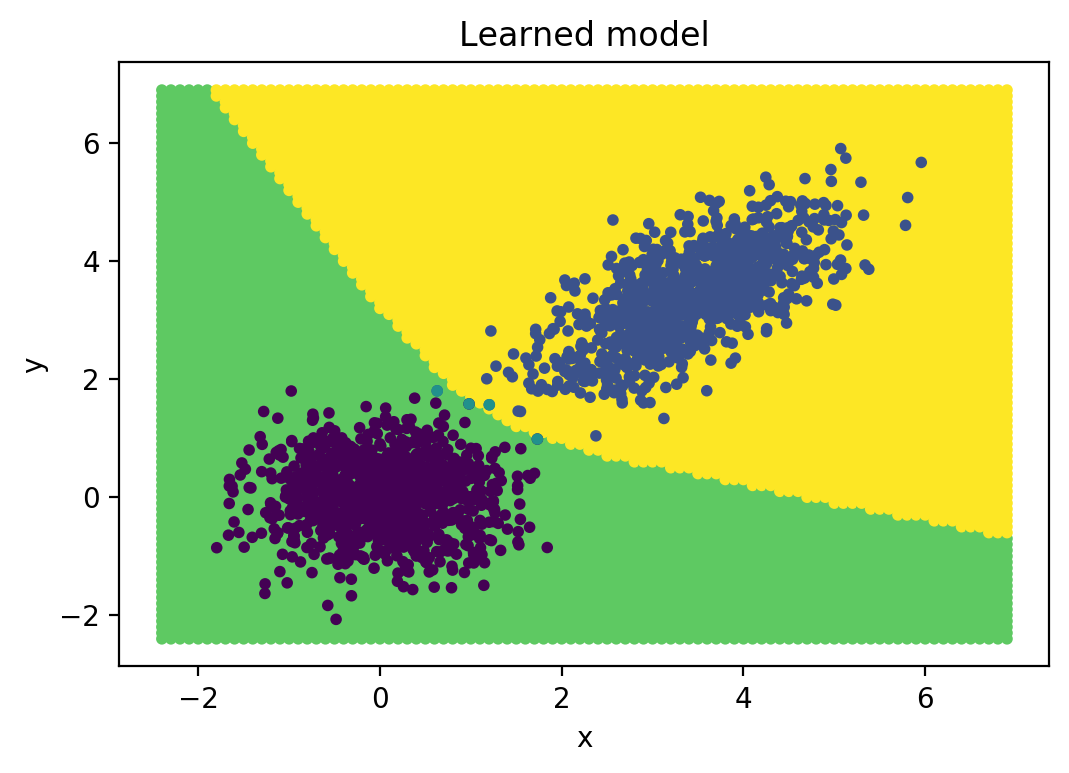

In [11]:
mpx=[]
mpy=[]
mc=[]
model.eval()

#compute the model estimation for all the points on a grid
for i in np.arange(-2.4,7,0.1):
    for j in np.arange(-2.4,7,0.1):
        xl=[i,j]
        y_pred=model.forward(torch.tensor(xl)).detach().numpy()[0]
        mpx.append(i)
        mpy.append(j)
        if y_pred<0.5:
            mc.append(3)
        else:
            mc.append(4)
            
#add the original points and bad classification from previous section
mpx+=px
mpy+=py
mc+=c
                             
plt.scatter(mpx,mpy,c=mc,s=10)
plt.title("Learned model")
plt.xlabel("x")
plt.ylabel("y")
plt.show()